# CNN autoencoder

In [1]:
import numpy as np
from sent_dataset import SentenceDataset
from utils import prepare_sample

In [33]:
import tensorflow as tf
def conv1d(inputs, filters, kernel_size, name=None, strides=1, padding="same", activation=tf.nn.relu):
    return tf.layers.conv1d(
        inputs      = inputs,
        filters     = filters,
        kernel_size = kernel_size,
        padding     = padding,
        activation  = activation,
        strides     = strides,
        name        = name)


def maxpool1d(inputs, pool_size, strides=None, padding="valid"):
    strides = strides or pool_size
    return tf.layers.max_pooling1d(
        inputs    = inputs, 
        pool_size = pool_size, 
        strides   = strides,
        padding   = padding)


def conv_maxpool_1d(inputs, filters, kernel_size, pool_size, activation=tf.nn.relu):
    return maxpool1d(conv1d(inputs, filters, kernel_size, activation=activation), pool_size)


def dense(inputs, units, name=None, activation=tf.nn.relu):
    return tf.layers.dense(inputs, units=units, activation=activation, name=name)


def flatten(inputs):
    return tf.contrib.layers.flatten(inputs)

    

In [53]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats

class AutoencoderCNN:
    def __init__(self):
        self._scope    = "autoencoder_cnn"
        self._session  = None
        self._graph    = None        
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []

    def _make_network(self, inputs, sent_len, voc_size, emb_size):
        with tf.variable_scope("simple_conv"):
            l = inputs
            l = conv_maxpool_1d (l,  128, 5, 2)
            l = conv_maxpool_1d (l,  128, 5, 2)
            l = conv_maxpool_1d (l,  128, 5, 2)
            # l = conv_maxpool_1d (l,  128, 5, 8)

            l = flatten(l)

            l = dense(l, 1024)
            l = dense(l, emb_size)
            l = dense(l, sent_len*voc_size, activation=None)

            l = tf.reshape(l, [-1, sent_len, voc_size])

            logits = l
            
            return logits
    

    def _make_loss(self, logits, labels):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits = logits,
            labels = labels,
        )
        return tf.reduce_mean(loss)
    

    def build(self, emb_size, voc_size, sent_len):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default(), tf.variable_scope(self._scope):
            
            # placeholders
            self.inputs_pl     = tf.placeholder(tf.int32, [None, sent_len], name='inputs')
            self.targets_pl    = tf.identity(self.inputs_pl, name='targets')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # embedding
            embedding_mtx      = tf.Variable(tf.random_normal(shape=[voc_size, emb_size], dtype=tf.float32))
            embed              = tf.nn.embedding_lookup(embedding_mtx, self.inputs_pl)
            
            # network
            logits             = self._make_network(embed, sent_len, voc_size, emb_size)
            self.outputs       = tf.argmax(tf.nn.softmax(logits), axis=2)

            # training
            self.loss_op       = self._make_loss(logits, self.targets_pl)
            self.train_op      = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)            
            
            # utils
            self.init_op       = tf.global_variables_initializer()
            self._saver        = tf.train.Saver()

        # session
        self._sess = tf.Session(graph=self._graph)
        self._sess.run(self.init_op)
        
        
    def train(self, tr_dataset, step_num, batch_size, learning_rate, log_every=20, mean_win=30):
        try:
            data_size = tr_dataset.get_data_size()
            for self.tr_step in range(self.tr_step, step_num-1):
                ep = self.tr_step*batch_size/data_size
                # Train
                sents = tr_dataset.get_next_batch(batch_size)
                tr_loss, _ = self._sess.run(
                    [self.loss_op, self.train_op], 
                    feed_dict={
                        self.inputs_pl:  sents,
                        self.targets_pl: sents,
                        self.lr_pl:       learning_rate
                    })
                self.tr_losses.append(tr_loss)

                if self.tr_step % log_every == 0:
                    show_train_stats(ep, self.tr_step, self.tr_losses, mean_win)
                        
        except KeyboardInterrupt:
            show_train_stats(ep, self.tr_step, self.tr_losses, mean_win)
            

    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses], open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
        
    def restore(self, path):
        try:
             [self.tr_epoch, self.tr_step, self.tr_losses] = pickle.load(open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)

        
    def run(self, sents):
        return self._sess.run(self.outputs, feed_dict={self.inputs_pl: sents})


## Dataset

In [81]:
%%time
dataset = SentenceDataset(2, 32)
dataset.load('data/dostoevsky.txt', 1000000)  # dostoevsky.txt  anna.txt

CPU times: user 4.72 s, sys: 16 ms, total: 4.73 s
Wall time: 4.69 s


In [82]:
voc_size = dataset.num_tokens
sent_len = dataset.max_len+2
print(dataset.get_data_size())
print("%d x %d = %d" % (voc_size, sent_len, voc_size*sent_len))

12311
25975 x 34 = 883150


## Build

In [83]:
%%time
model_path  = 'models/autoencoder/dostoevsky-001/'

model = AutoencoderCNN()

model.build(
    emb_size  = 100,
    voc_size  = voc_size, 
    sent_len  = sent_len)

CPU times: user 1.66 s, sys: 72 ms, total: 1.74 s
Wall time: 1.84 s


## Train

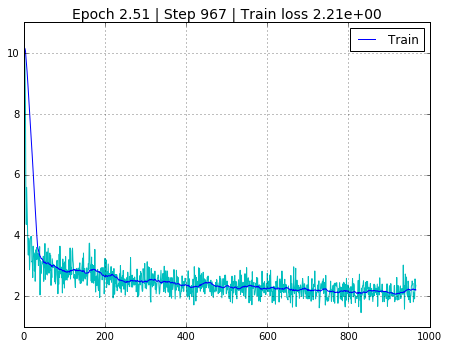

CPU times: user 2min 21s, sys: 30.8 s, total: 2min 52s
Wall time: 2min 43s


In [84]:
%%time
model.train(
    step_num      = 10000,
    batch_size    = 32, 
    learning_rate = 1e-3, 
    mean_win      = 30,
    tr_dataset    = dataset)
model.save(model_path)

## Test

In [85]:
inp = dataset.get_next_batch(3)
for s in inp:
    print('[%s]' % dataset.decode(s).replace(' _', ''))
out = model.run(inp)
print('-'*100)
for s in out:
    print('[%s]' % dataset.decode(s).replace(' _', ''))


[<BOS> прасковья ивановна замахала руками . <EOS>]
[<BOS> мы только переглянулись с кирилловым и решили , что это хорошо и что это нам очень нравится <EOS>]
[<BOS> — он топнул опять ногой , слюня брызгала с его губ . <EOS>]
----------------------------------------------------------------------------------------------------
[<BOS> — , , . <EOS> <EOS>]
[<BOS> — , , , , , , , , , , , , , . . . <EOS>]
[<BOS> — , , , , , , , , . . <EOS>]


## Restore

In [55]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/autoencoder/dostoevsky-001/


INFO:tensorflow:Restoring parameters from models/autoencoder/dostoevsky-001/
